# HW4

The objective of this assignment is to compare the performance of three different parameter configurations of an ACO algorithm applied to the asymmetric TSP.

Consider the following points.

Problem instances

Use the following TSP instances from TSPLIB (http://comopt.ifi.uni-heidelberg.de/software/TSPLIB95/):

- br17
- ft53
- kro124

Note that the instances correspond mainly to the asymmetric TSP version.

ACO configurations

Implement an ACO algorithm for TSP and define three different configurations for the parameters:

- $\alpha$: influence of pheromone
- $\beta$: influence of heuristic information
- $\rho$: pheromone evaporation rate

Note that each configuration tuple $(\alpha, \beta, \rho)$ defines a separate experiment. You must compare the performance of these three configurations on all three problem instances.

### Implementation

- The ACO algorithm must be implemented from scratch.
- The use of optimization frameworks (metaheuristic libraries) is not allowed.
- You may use libraries only for: reading and parsing TSPLIB instances (although you may not need this), and visualization of results (plots, charts, etc.). Clearly document any external libraries you use.

### Experimental design

For each problem instance (br17, ft53, kro124) and each parameter configuration:

- Perform 31 independent runs.
- For each set of runs, report:
  - Best final solution from each execution.
  - Number of times the best known value was reached.
  - Descriptive statistics over the 31 runs: mean, median, standard deviation.
  - Statistical significance analysis using the Wilcoxon rank-sum test to compare configurations.

- Provide an analytical discussion on which configuration performs best for each problem, supported by well-organized tables, charts, and figures.


In [17]:
# 1) Imports and global settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import re
from pathlib import Path
import gzip
import json

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (8, 5)

PROJECT_ROOT = Path('..')  # dataset files are one directory up from this notebook
FIGS_DIR = Path('figs')
RESULTS_DIR = Path('results_nb')
FIGS_DIR.mkdir(exist_ok=True)
RESULTS_DIR.mkdir(exist_ok=True)

print('Working directory:', Path.cwd())
print('Project root exists:', PROJECT_ROOT.exists())
print('Figures dir:', FIGS_DIR.resolve())
print('Results dir:', RESULTS_DIR.resolve())


Working directory: /home/raqcoss/Shared/Notebook/Evolutionary Computing/EvoComputing
Project root exists: True
Figures dir: /home/raqcoss/Shared/Notebook/Evolutionary Computing/EvoComputing/figs
Results dir: /home/raqcoss/Shared/Notebook/Evolutionary Computing/EvoComputing/results_nb


In [18]:
# 2) TSPLIB parser utilities
def open_text_any(path: Path):
    """Open a possibly gzipped text file and return an iterator over lines.
    Supports .gz or plain text.
    """
    if str(path).endswith('.gz'):
        return gzip.open(path, 'rt', encoding='utf-8', errors='ignore')
    return open(path, 'r', encoding='utf-8', errors='ignore')

def parse_tsplib(filename: Path):
    """
    Parse a TSPLIB ATSP instance and return (name, n_cities, distance_matrix, best_known).
    Handles EDGE_WEIGHT_FORMAT: FULL_MATRIX.
    """
    with open_text_any(filename) as f:
        lines = f.readlines()

    name = None
    n_cities = None
    edge_weight_format = None
    best_known = None

    data_start = 0
    for i, raw in enumerate(lines):
        line = raw.strip()
        if line.startswith('NAME'):
            name = line.split(':', 1)[1].strip() if ':' in line else line.split()[-1]
        elif line.startswith('DIMENSION'):
            n_cities = int(line.split(':', 1)[1].strip())
        elif line.startswith('EDGE_WEIGHT_FORMAT'):
            edge_weight_format = line.split(':', 1)[1].strip()
        elif line.startswith('EDGE_WEIGHT_SECTION'):
            data_start = i + 1
            break
        elif line.startswith('COMMENT') and 'best' in line.lower():
            m = re.search(r'(\d+)', line)
            if m:
                best_known = int(m.group(1))

    if n_cities is None:
        raise ValueError('DIMENSION not parsed in TSPLIB file: ' + str(filename))

    distance_matrix = np.zeros((n_cities, n_cities), dtype=float)

    if edge_weight_format == 'FULL_MATRIX':
        data = []
        for raw in lines[data_start:]:
            line = raw.strip()
            if not line or line.upper() == 'EOF':
                continue
            data.extend(map(float, line.split()))
        idx = 0
        for i in range(n_cities):
            for j in range(n_cities):
                distance_matrix[i, j] = data[idx]
                idx += 1
    else:
        raise ValueError(f'Unsupported EDGE_WEIGHT_FORMAT: {edge_weight_format}')

    return name, n_cities, distance_matrix, best_known

def find_instance_file(filename: str) -> Path | None:
    """Try to locate the instance either in project root or current directory,
    supporting plain or .gz files.
    """
    candidates = [
        PROJECT_ROOT / filename,
        Path('.') / filename,
        PROJECT_ROOT / (filename + '.gz'),
        Path('.') / (filename + '.gz'),
    ]
    for p in candidates:
        if p.exists():
            return p
    return None


In [19]:
# 3) Ant Colony Optimization (ACO) for (A)TSP
class ACO:
    def __init__(self, distance_matrix, n_ants=30, n_iterations=100,
                 alpha=1.0, beta=2.0, rho=0.1, q=100, seed=None):
        self.distance_matrix = distance_matrix.astype(float)
        self.n_cities = distance_matrix.shape[0]
        self.n_ants = n_ants
        self.n_iterations = n_iterations
        self.alpha = float(alpha)
        self.beta = float(beta)
        self.rho = float(rho)
        self.q = float(q)

        if seed is not None:
            np.random.seed(seed)

        # Initialize pheromone matrix
        self.tau = np.ones((self.n_cities, self.n_cities), dtype=float) / self.n_cities

        self.best_tour = None
        self.best_distance = np.inf
        self.convergence_history = []

    def heuristic_value(self, i, j):
        d = self.distance_matrix[i, j]
        return 1.0 / (d + 1e-10)

    def _select_next_city(self, current, unvisited):
        candidates = list(unvisited)
        desirability = []
        for nxt in candidates:
            pher = self.tau[current, nxt] ** self.alpha
            heur = self.heuristic_value(current, nxt) ** self.beta
            desirability.append(pher * heur)
        probs = np.array(desirability, dtype=float)
        s = probs.sum()
        if s <= 0 or not np.isfinite(s):
            probs = np.ones_like(probs) / len(probs)
        else:
            probs /= s
        return np.random.choice(candidates, p=probs)

    def construct_ant_tour(self):
        tour = []
        unvisited = set(range(self.n_cities))
        current = np.random.randint(self.n_cities)
        tour.append(current)
        unvisited.remove(current)
        while unvisited:
            nxt = self._select_next_city(current, unvisited)
            tour.append(nxt)
            unvisited.remove(nxt)
            current = nxt
        return tour

    def tour_distance(self, tour):
        dist = 0.0
        for i in range(len(tour)):
            dist += self.distance_matrix[tour[i], tour[(i + 1) % len(tour)]]
        return dist

    def update_pheromone(self, ants_tours, ants_distances):
        # Evaporate
        self.tau *= (1.0 - self.rho)
        # Deposit
        for tour, distance in zip(ants_tours, ants_distances):
            if distance <= 0:
                continue
            deposit = self.q / distance
            for i in range(len(tour)):
                j = tour[(i + 1) % len(tour)]
                self.tau[tour[i], j] += deposit

    def run(self):
        for _ in range(self.n_iterations):
            ants_tours = [self.construct_ant_tour() for _ in range(self.n_ants)]
            ants_distances = [self.tour_distance(t) for t in ants_tours]

            best_idx = int(np.argmin(ants_distances))
            if ants_distances[best_idx] < self.best_distance:
                self.best_distance = float(ants_distances[best_idx])
                self.best_tour = list(ants_tours[best_idx])

            self.convergence_history.append(self.best_distance)
            self.update_pheromone(ants_tours, ants_distances)
        return self.best_tour, self.best_distance


In [20]:
# 4) Instances and configurations
instances = {
    'br17':   {'best_known': 39,    'file': 'br17.atsp'},
    'ft53':   {'best_known': 6905,  'file': 'ft53.atsp'},
    'kro124': {'best_known': 36230, 'file': 'kro124p.atsp'},
}

# Optional: run only a subset of instances to save time.
# Example to run only br17: RUN_ONLY = ['br17']
# Set to None or [] to run all.
RUN_ONLY = ['br17']

configurations = {
    'Config1': {'alpha': 1.0, 'beta': 2.0, 'rho': 0.10},
    'Config2': {'alpha': 2.0, 'beta': 1.0, 'rho': 0.05},
    'Config3': {'alpha': 0.5, 'beta': 3.0, 'rho': 0.20},
}

print('Instances:')
for k, v in instances.items():
    if RUN_ONLY and k not in RUN_ONLY:
        print(f'  - {k}: SKIPPED (filtered)')
        continue
    p = find_instance_file(v['file'])
    print(f'  - {k}:', p if p else 'NOT FOUND')
print('Configurations:')
for k, v in configurations.items():
    print('  -', k, v)


Instances:
  - br17: ../br17.atsp
  - ft53: SKIPPED (filtered)
  - kro124: SKIPPED (filtered)
Configurations:
  - Config1 {'alpha': 1.0, 'beta': 2.0, 'rho': 0.1}
  - Config2 {'alpha': 2.0, 'beta': 1.0, 'rho': 0.05}
  - Config3 {'alpha': 0.5, 'beta': 3.0, 'rho': 0.2}


In [21]:
# 5) Run experiments (31 runs per config/instance)
N_RUNS = 31


results = {}  # results[instance][config] -> dict

for instance_name, info in instances.items():
    print('' + '='*68)
    print('Processing instance:', instance_name)
    print('='*68)

    path = find_instance_file(info['file'])
    if not path:
        print('  File not found for instance', instance_name, '->', info['file'])
        continue

    name, n_cities, dist_mat, _ = parse_tsplib(path)
    best_known = info['best_known']
    results[instance_name] = {}

    for cfg_name, params in configurations.items():
        print(f'  Configuration: {cfg_name} with params {params}')
        best_solutions = []
        times_best_known = 0

        for run in range(N_RUNS):
            aco = ACO(dist_mat, n_ants=30, n_iterations=100,
                      alpha=params['alpha'], beta=params['beta'],
                      rho=params['rho'], q=100, seed=run)
            tour, dist_val = aco.run()
            best_solutions.append(dist_val)
            if int(round(dist_val)) == best_known:
                times_best_known += 1
            if (run + 1) % 10 == 0:
                print(f'    Run {run + 1}/{N_RUNS} completed. Current best: {min(best_solutions):.4f}')

        arr = np.array(best_solutions, dtype=float)
        results[instance_name][cfg_name] = {
            'best_solutions': best_solutions,
            'mean': float(np.mean(arr)),
            'median': float(np.median(arr)),
            'std': float(np.std(arr, ddof=0)),
            'min': float(np.min(arr)),
            'max': float(np.max(arr)),
            'times_best_known': int(times_best_known),
            'best_known': int(best_known),
        }

print('Done running experiments.')


Processing instance: br17
  Configuration: Config1 with params {'alpha': 1.0, 'beta': 2.0, 'rho': 0.1}
    Run 10/31 completed. Current best: 39.0000
    Run 20/31 completed. Current best: 39.0000
    Run 30/31 completed. Current best: 39.0000
  Configuration: Config2 with params {'alpha': 2.0, 'beta': 1.0, 'rho': 0.05}
    Run 10/31 completed. Current best: 39.0000
    Run 20/31 completed. Current best: 39.0000
    Run 30/31 completed. Current best: 39.0000
  Configuration: Config3 with params {'alpha': 0.5, 'beta': 3.0, 'rho': 0.2}
    Run 10/31 completed. Current best: 39.0000
    Run 20/31 completed. Current best: 39.0000
    Run 30/31 completed. Current best: 39.0000
Processing instance: ft53
  Configuration: Config1 with params {'alpha': 1.0, 'beta': 2.0, 'rho': 0.1}


KeyboardInterrupt: 

In [22]:
# 6) Build summary tables
summary_rows = []
for inst, cfgs in results.items():
    for cfg, d in cfgs.items():
        summary_rows.append({
            'Instance': inst,
            'Configuration': cfg,
            'Mean': d['mean'],
            'Median': d['median'],
            'Std Dev': d['std'],
            'Min': d['min'],
            'Max': d['max'],
            'Times Best Known': d['times_best_known'],
            'Best Known': d['best_known'],
        })
summary_df = pd.DataFrame(summary_rows)
print('SUMMARY STATISTICS TABLE')
if not summary_df.empty:
    display(summary_df)
    # Save per-instance summaries
    for inst in summary_df['Instance'].unique():
        out = summary_df[summary_df['Instance'] == inst]
        out.to_csv(RESULTS_DIR / f'summary_{inst}.csv', index=False)
else:
    print('No results to summarize (files missing?).')


SUMMARY STATISTICS TABLE


,Instance,Configuration,Mean,Median,Std Dev,Min,Max,Times Best Known,Best Known
0,br17,Config1,39.0,39.0,0.0,39.0,39.0,31,39
1,br17,Config2,39.0,39.0,0.0,39.0,39.0,31,39
2,br17,Config3,39.0,39.0,0.0,39.0,39.0,31,39


In [12]:
# 7) Statistical significance: Wilcoxon rank-sum (Mann–Whitney U) test
print('' + '='*80)
print('WILCOXON RANK-SUM TEST (pairwise configuration comparisons)')
print('='*80)

if results:
    for inst, cfgs in results.items():
        print(f'{inst}:')
        cfg_names = list(cfgs.keys())
        for i in range(len(cfg_names)):
            for j in range(i+1, len(cfg_names)):
                c1, c2 = cfg_names[i], cfg_names[j]
                s1 = cfgs[c1]['best_solutions']
                s2 = cfgs[c2]['best_solutions']
                # Mann–Whitney U (a.k.a. Wilcoxon rank-sum)
                stat, p = stats.mannwhitneyu(s1, s2, alternative='two-sided')
                print(f'  {c1} vs {c2}: p-value = {p:.6g}',
                      '(significant)' if p < 0.05 else '(not significant)')
else:
    print('No results to test.')

WILCOXON RANK-SUM TEST (pairwise configuration comparisons)
br17:
  Config1 vs Config2: p-value = 1 (not significant)
  Config1 vs Config3: p-value = 1 (not significant)
  Config2 vs Config3: p-value = 1 (not significant)
ft53:
  Config1 vs Config2: p-value = 1.41346e-09 (significant)
  Config1 vs Config3: p-value = 1.5438e-11 (significant)
  Config2 vs Config3: p-value = 0.772874 (not significant)
kro124:
  Config1 vs Config2: p-value = 0.724862 (not significant)
  Config1 vs Config3: p-value = 2.2716e-11 (significant)
  Config2 vs Config3: p-value = 5.88867e-11 (significant)


In [13]:
# 8) Visualization utilities
def plot_times_best_known(summary_df: pd.DataFrame):
    if summary_df.empty:
        print('No data for plotting.')
        return
    dfp = summary_df.pivot(index='Configuration', columns='Instance', values='Times Best Known')
    ax = dfp.plot(kind='bar', figsize=(10, 6))
    ax.set_ylabel('Number of times best known was reached (31 runs)')
    ax.set_title('Times best-known value reached per configuration and instance')
    ax.legend(title='Instance')
    plt.tight_layout()
    plt.show()
    plt.savefig(FIGS_DIR / 'aco_times_best_known.png', bbox_inches='tight')

def plot_boxplots(results: dict):
    if not results:
        print('No data for plotting.')
        return
    for inst, cfgs in results.items():
        labels = []
        data = []
        for cfg, d in cfgs.items():
            labels.append(cfg)
            data.append(d['best_solutions'])
        plt.figure(figsize=(8,5))
        plt.boxplot(data, labels=labels, showfliers=False)
        plt.ylabel('Final tour length')
        plt.title(f'Best final solutions over 31 runs - {inst}')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
        plt.savefig(FIGS_DIR / f'aco_boxplot_{inst}.png', bbox_inches='tight')

def plot_mean_performance(summary_df: pd.DataFrame):
    if summary_df.empty:
        return
    dfp = summary_df.pivot(index='Configuration', columns='Instance', values='Mean')
    ax = dfp.plot(kind='bar', figsize=(10,6))
    ax.set_ylabel('Mean final tour length (31 runs)')
    ax.set_title('Mean performance per configuration and instance')
    ax.legend(title='Instance')
    plt.tight_layout()
    plt.show()
    plt.savefig(FIGS_DIR / 'aco_mean_performance.png', bbox_inches='tight')


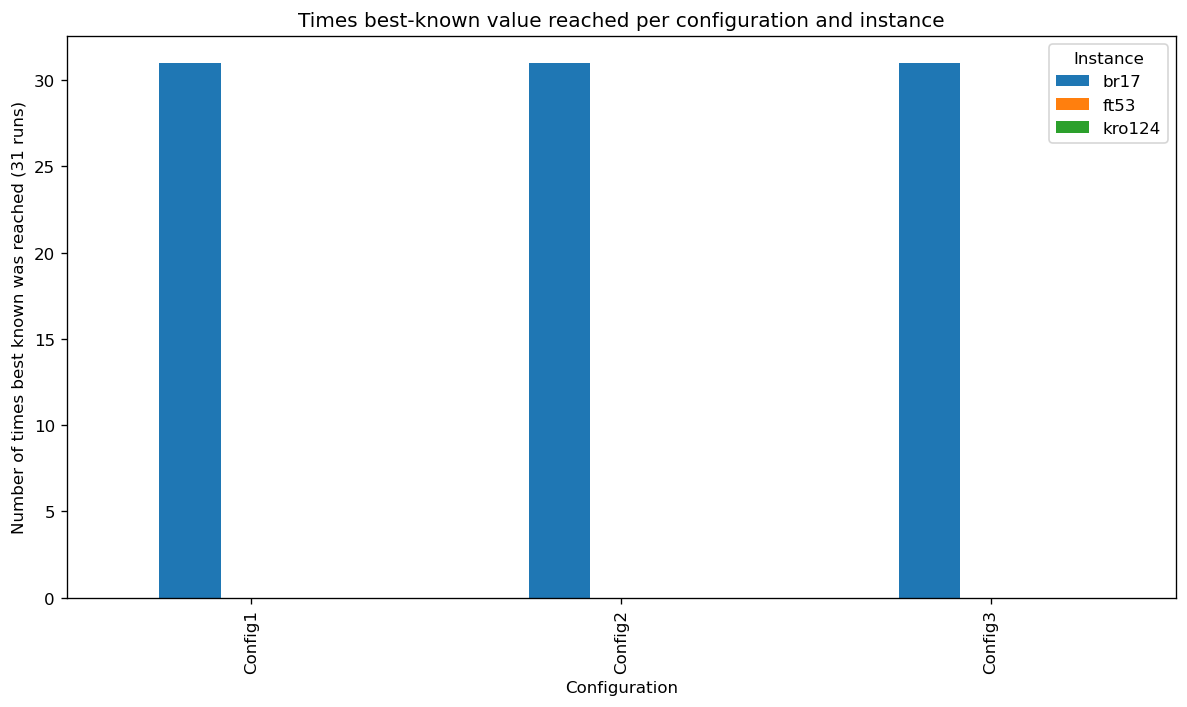

/tmp/ipykernel_91086/262597830.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


<Figure size 960x600 with 0 Axes>

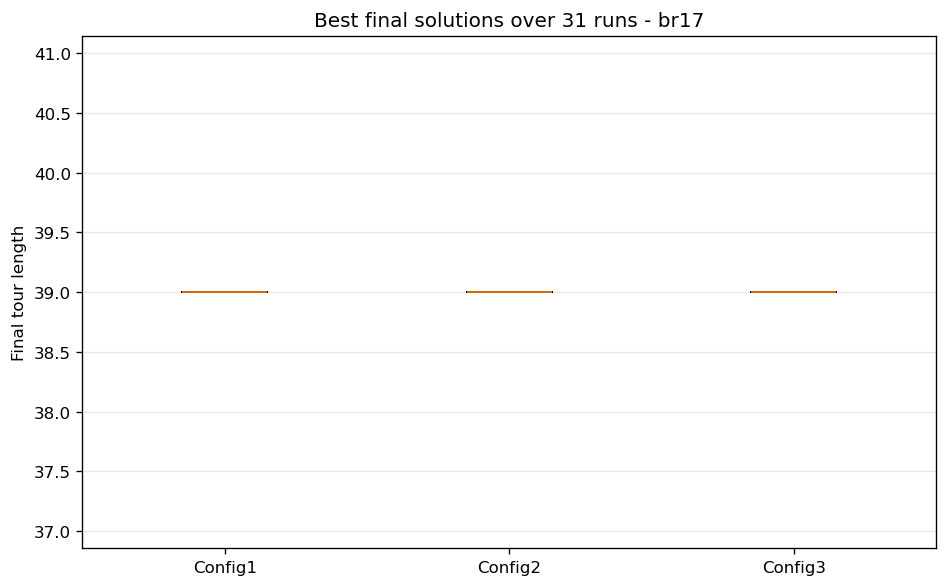

/tmp/ipykernel_91086/262597830.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


<Figure size 960x600 with 0 Axes>

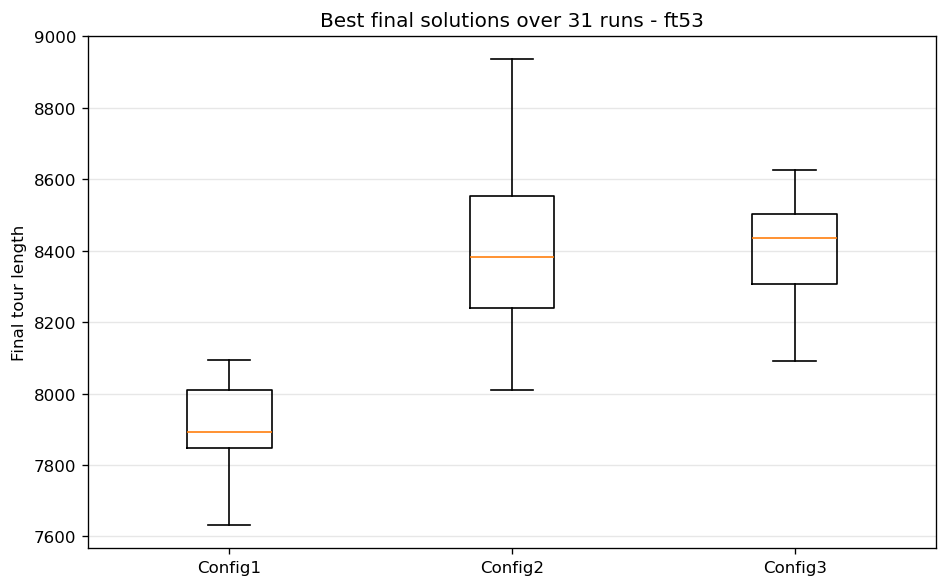

/tmp/ipykernel_91086/262597830.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showfliers=False)


<Figure size 960x600 with 0 Axes>

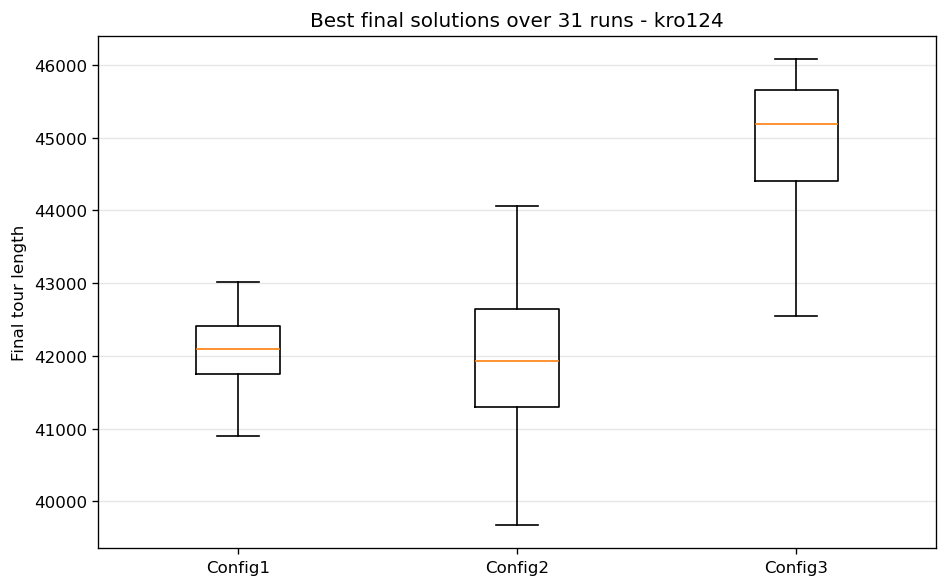

<Figure size 960x600 with 0 Axes>

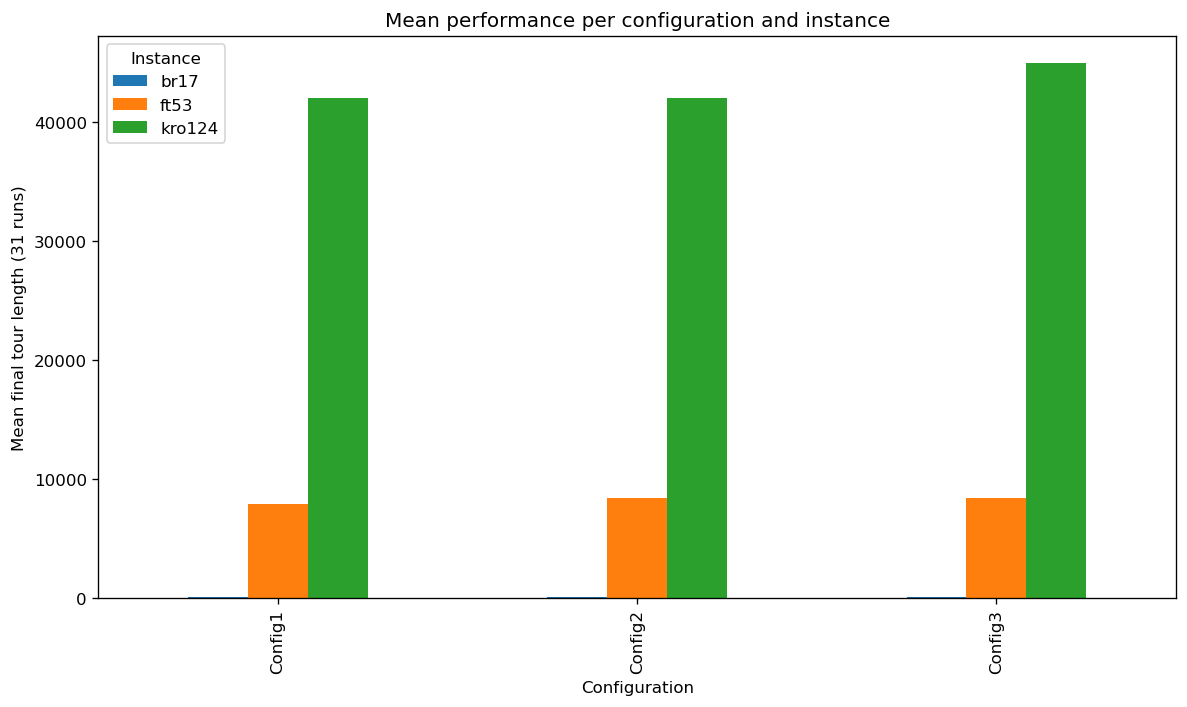

<Figure size 960x600 with 0 Axes>

In [14]:
# 9) Render visualizations
if not summary_df.empty:
    plot_times_best_known(summary_df)
    plot_boxplots(results)
    plot_mean_performance(summary_df)
else:
    print('Skipping plots: no summary data.')


Your report must follow a scientific structure with the following sections:

1. Abstract

2. Introduction

3. Background

    - Problem (asymmetric TSP)

    - Algorithms (ACO and parameter roles: $\alpha, \beta, \rho$)

4. Experimental Setup

    - Implementation details

    - Parameter configurations

    - Experimental protocol (runs, stopping criteria, etc.)

5. Results

    - Tables and plots for each instance and configuration

    - Statistical tests

    - Discussion and interpretation

6. Conclusion

The document should be written in LaTeX